# Emperical experiment for StreamingCNN

To evaluate whether a neural network using streaming trains equivalently to the conventional training, we can train a CNN on small images using both methods, starting from the same initialization. We used a subset of the ImageNet dataset, [ImageNette](https://github.com/fastai/imagenette), using 100 examples of 10 ImageNet classes (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute).

In [1]:
import os
import copy
import random

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from IPython.display import clear_output

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.6"
from scnn import StreamingCNN

/home/sharaf/Projects/scnn/StreamingCNN/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using /home/sharaf/.cache/torch_extensions as PyTorch extensions root...
Emitting ninja build file /home/sharaf/.cache/torch_extensions/cpp_functions/build.ninja...
Building extension module cpp_functions...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module cpp_functions...


In [2]:
torch.set_printoptions(precision=10)
torch.manual_seed(0)

In [3]:
# to compare the networks we want to train deterministically
torch.backends.cudnn.deterministic = True

# Download the dataset

In [4]:
if not os.path.isfile('imagenette2-320.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
    !tar -xvf imagenette2-320.tgz

# Model definition

In [5]:
class StreamNet(torch.nn.Sequential):
    def __init__(self):
        super(StreamNet, self).__init__(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), torch.nn.ReLU(inplace=True),
            torch.nn.AdaptiveMaxPool2d(1)
        )

        self.classifier = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [7]:
stream_net = StreamNet().cuda()
net = Net().cuda()

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
count_parameters(stream_net) + count_parameters(net)

395178

# Configure streamingSGD

In [10]:
sCNN = StreamingCNN(stream_net, tile_shape=(1, 3, 32, 32), deterministic=True, verbose=True)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 Lost(top:1.0, left:1.0, bottom:1.0, right:1.0)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
 Lost(top:1.0, left:1.0, bottom:1.0, right:1.0)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 Lost(top:2.0, left:2.0, bottom:2.0, right:2.0)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
 Lost(top:1.0, left:1.0, bottom:1.0, right:1.0)

 Output lost Lost(top:1.0, left:1.0, bottom:1.0, right:1.0)

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
 Lost(top:1.0, left:1.0, bottom:1.0, right:1.0)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 Lost(top:2.0, left:2.0, bottom:2.0, right:2.0)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
 Lost(top:3.0, left:3.0, bottom:3.0, right:3.0)
Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 Lost(top:6.0, left:6.0, bottom:

/home/sharaf/Projects/scnn/StreamingCNN/venv/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [11]:
sCNN.verbose = False


# Create dataloaders

In [12]:
class ImagenetteDataset(object):
    def __init__(self, patch_size=320, validation=False, should_normalize=True):
        self.folder = Path('imagenette2-320/train') if not validation else Path('imagenette2-320/val')
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079',
                        'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

        self.images = []
        for cls in self.classes:
            cls_images = list(self.folder.glob(cls + '/*.JPEG'))
            self.images.extend(cls_images)
        
        self.patch_size = patch_size
        self.validation = validation
        
        self.random_resize = torchvision.transforms.RandomResizedCrop(patch_size)
        self.center_resize = torchvision.transforms.CenterCrop(patch_size)
        self.should_normalize = should_normalize
        self.normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __getitem__(self, index):
        image_fname = self.images[index]
        image = Image.open(image_fname)
        label = image_fname.parent.stem
        label = self.classes.index(label)
        
        if not self.validation: image = self.random_resize(image)
        else: image = self.center_resize(image)
            
        image = torchvision.transforms.functional.to_tensor(image)
        if image.shape[0] == 1: image = image.expand(3, 320, 320)
        if self.should_normalize: image = self.normalize(image)
        
        return image, label

    def __len__(self):
        return len(self.images)

In [13]:
trainset = ImagenetteDataset(320)
valset = ImagenetteDataset(320, validation=True)

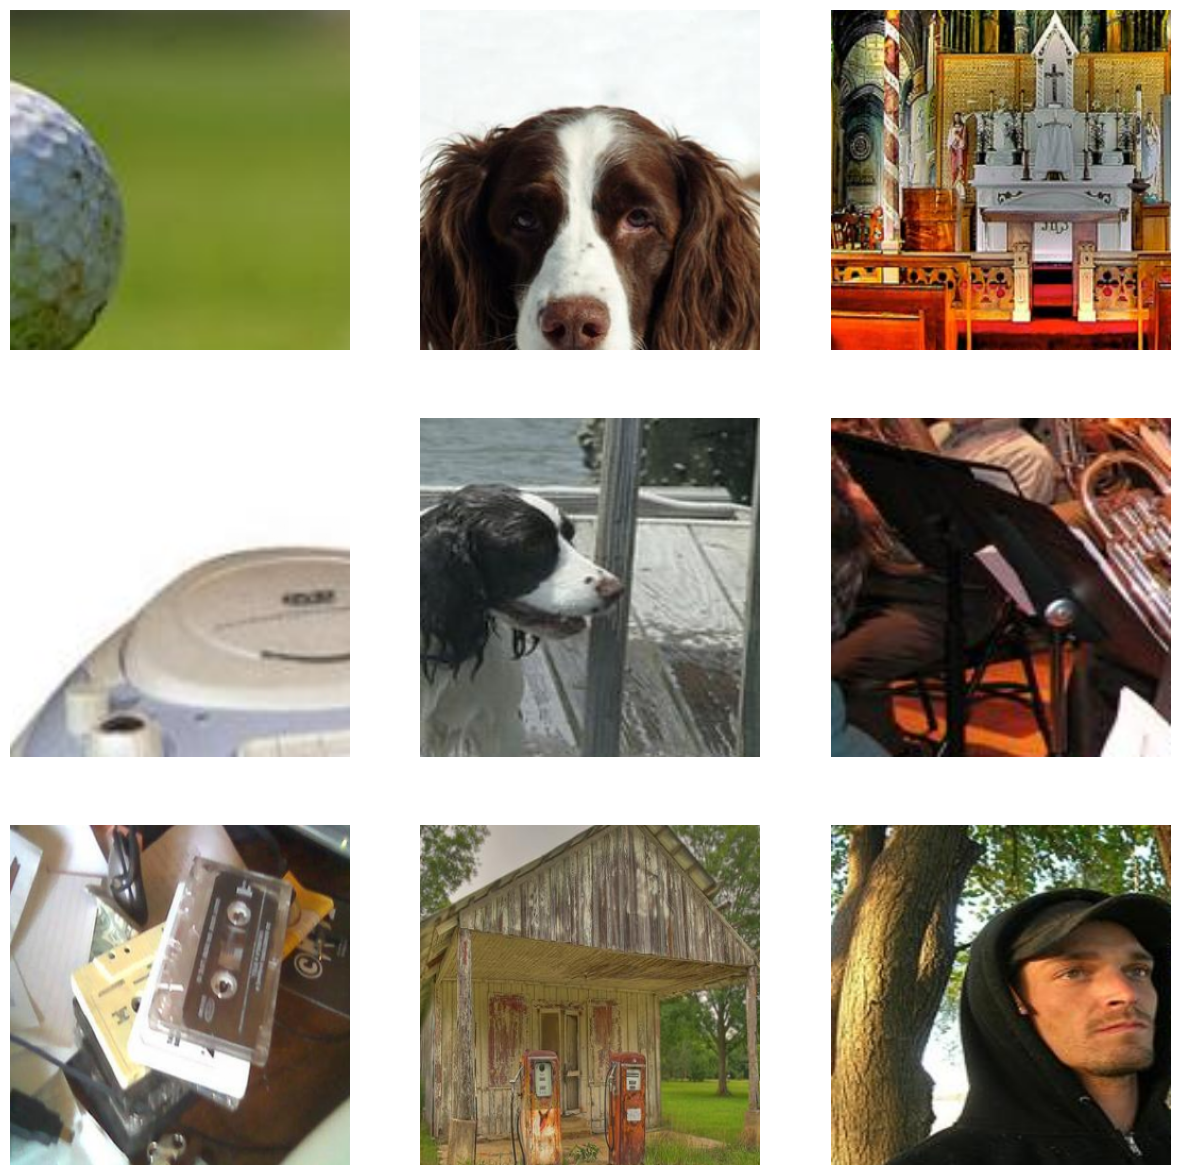

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
visualize_trainset = ImagenetteDataset(320, should_normalize=False)

for y in range(3):
    for x in range(3):
        index = random.randint(0, len(trainset) - 1)
        sample = visualize_trainset[index]
        ax[y, x].imshow(sample[0].numpy().transpose(1,2,0))
        ax[y, x].set_axis_off()

plt.show(); 

# Initialize network and optimizer

In [15]:
for mod in net.modules():
    if isinstance(mod, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(mod.weight, nonlinearity='relu')
        mod.bias.data.fill_(0)

In [16]:
# save parameters so that we can start networks from the same initialization
original_initialization_stream_net = copy.deepcopy(stream_net.state_dict())
original_initialization_net = copy.deepcopy(net.state_dict())

In [17]:
params = list(stream_net.parameters()) + list(net.parameters())

In [18]:
criterion = torch.nn.CrossEntropyLoss()

In [19]:
optimizer = torch.optim.SGD(params, lr=1e-3, weight_decay=1e-6)

In [20]:
batch_size = 32

In [21]:
stream_losses = []
stream_val_losses = []
stream_val_accuracy = []

# Training

In [ ]:
losses = []
stream_losses = []
val_losses = []
stream_val_losses = []
val_accuracy = []
stream_val_accuracy = []

def run(epochs=100, streaming=False):
    global losses, stream_losses, val_losses, stream_val_losses
    global val_accuracy, stream_val_accuracy
    # sCNN uses hooks to correct gradients while streaming, 
    # so we have to disable it when training conventionally
    if streaming: sCNN.enable()
    else: sCNN.disable()
    
    for epoch in range(epochs):
        running_loss = 0.0
        i = 0
        
        for images, labels in tqdm(trainloader):
            # first inference / stream through first network
            if streaming: 
                with torch.no_grad():
                    first_output = sCNN.forward(images)
                first_output.requires_grad = True
            else: 
                first_output = stream_net.forward(images.cuda())

            labels = labels.cuda()
            
            # inference final part of network
            second_output = net(first_output)

            # backpropagation through final network
            loss = criterion(second_output, labels)
            loss.backward()

            # backpropagation through first network using checkpointing / streaming
            if streaming: 
                sCNN.backward(images, first_output.grad)

            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()
            i += 1

                    
        if streaming: stream_losses.append(running_loss / i)
        else: losses.append(running_loss / i)

        running_loss = 0
        i = 0
        accurate = 0
        with torch.no_grad():
            for images, labels in valloader:
                if streaming: first_output = sCNN.forward(images.cuda())
                else: first_output = stream_net.forward(images.cuda())
                second_output = net(first_output)

                loss = criterion(second_output, labels.cuda())
                running_loss += loss.item()

                i += 1
                accurate += (torch.argmax(torch.softmax(second_output, dim=1), dim=1).cpu() == labels).sum() / float(len(images))
            
        if streaming: stream_val_accuracy.append(accurate / float(i))
        else: val_accuracy.append(accurate / float(i))
            
        if streaming: stream_val_losses.append(running_loss / i)
        else: val_losses.append(running_loss /  i)
            
        plot_losses()

def plot_losses():
    global losses, stream_losses, val_losses, stream_val_losses
    global val_accuracy, stream_val_accuracy
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    ax[0].plot(np.arange(len(losses)), losses, label="loss, normal case")
    ax[0].plot(np.arange(len(stream_losses)), stream_losses, label="loss, streaming", color="C1")
    ax[1].plot(np.arange(len(losses)), losses, label="train loss, normal case")
    ax[1].plot(np.arange(len(val_losses)), val_losses, label="validation loss, normal case")
    ax[2].plot(np.arange(len(stream_losses)), stream_losses, label="train loss, streaming", color="C1")
    ax[2].plot(np.arange(len(stream_val_losses)), stream_val_losses, label="validation loss, streaming", color="C2")
    ax[3].plot(np.arange(len(val_accuracy)), val_accuracy, label="normal accuracy")
    ax[3].plot(np.arange(len(stream_val_accuracy)), stream_val_accuracy, label="streaming accuracy")
    ax[0].legend() 
    ax[1].legend() 
    ax[2].legend() 
    ax[3].legend()
    plt.show();

In [23]:
torch.backends.cudnn.deterministic = True

## Train conventionally (not streaming)

In [24]:
losses = []
val_losses = []
val_accuracy = []

In [25]:
# load original state
stream_net.load_state_dict(original_initialization_stream_net)
net.load_state_dict(original_initialization_net)

<All keys matched successfully>

In [26]:
# initialize the dataloaders after re-seed, if we do this in both training cases the order is identical
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)

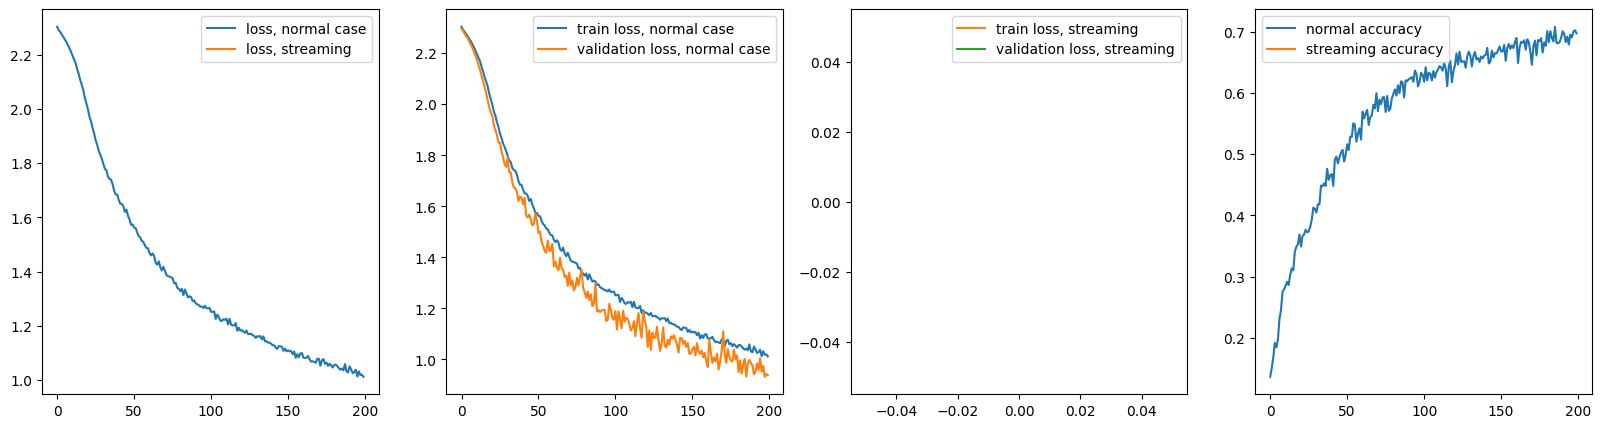

In [27]:
run(epochs=200, streaming=False) 

In [28]:
np.save('losses', losses)
np.save('val_losses', val_losses)
np.save('val_accuracy', val_accuracy)

---

## Train streaming

In [29]:
stream_losses = []
stream_val_losses = []
stream_val_accuracy = []

In [30]:
# load original state
stream_net.load_state_dict(original_initialization_stream_net)
net.load_state_dict(original_initialization_net)

<All keys matched successfully>

In [ ]:
# initialize the dataloaders after re-seed
torch.manual_seed(0)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=1)

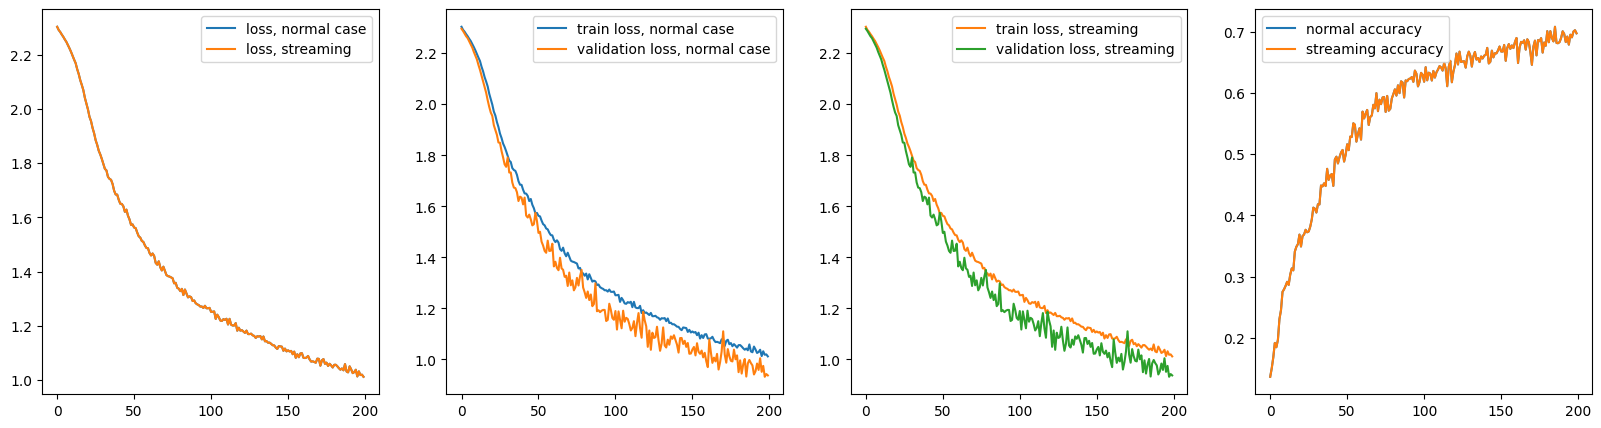

In [32]:
run(epochs=200, streaming=True)

In [33]:
np.save('stream_losses', stream_losses)
np.save('stream_val_losses', stream_val_losses)
np.save('stream_val_accuracy', stream_val_accuracy)

In [ ]:
torch.save(stream_net.state_dict(), 'stream_net_after_streaming')
torch.save(net.state_dict(), 'net_after_streaming')

---

In [1]:
import numpy as np

array = np.load('stream_val_losses.npy')
print(array)

[2.29602068 2.28739804 2.27699457 2.26666487 2.25910408 2.2469977
 2.23430826 2.22228231 2.20534617 2.19030485 2.17576892 2.15415818
 2.13496065 2.11259971 2.09170614 2.06676551 2.04536074 2.01607693
 1.98988385 1.96775647 1.95437826 1.91803016 1.89918797 1.87989323
 1.85017984 1.84899953 1.8169127  1.79213988 1.76455193 1.75478002
 1.79127567 1.73243144 1.73277943 1.69328351 1.67346832 1.67137869
 1.65541429 1.62060916 1.63792512 1.633874   1.60754904 1.63415067
 1.56377184 1.55604416 1.56742671 1.5491064  1.52533769 1.5296279
 1.57427572 1.54266144 1.49580277 1.50020716 1.46151586 1.44611901
 1.42525322 1.41781692 1.46547053 1.42491653 1.42595741 1.45334521
 1.36432322 1.38269242 1.35840295 1.34946122 1.39832665 1.35685148
 1.35113576 1.32363171 1.32782847 1.28775831 1.34030926 1.29032535
 1.30978458 1.2705847  1.28258004 1.31951845 1.2894927  1.32581657
 1.35062661 1.28181154 1.26304367 1.24084782 1.26608219 1.23241602
 1.25445566 1.20857018 1.21683848 1.29782226 1.18864236 1.192617